In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

## Load and preprocess data

In [2]:
# Load and preprocess data
def prepare_data(df, feature_col='Open', seq_length=10):
    scaler = MinMaxScaler()
    df[feature_col] = scaler.fit_transform(df[[feature_col]])
    
    X, y = [], []
    for i in range(len(df) - seq_length):
        X.append(df[feature_col].iloc[i:i+seq_length].values)
        y.append(df[feature_col].iloc[i+seq_length])
    
    return np.array(X), np.array(y), scaler

## Load data

In [3]:
# df = pd.read_csv("NVDA.csv")
df = pd.read_csv(r"C:\Users\dheen\.cache\kagglehub\datasets\meharshanali\nvidia-stocks-data-2025\versions\1\NVDA.csv")
df.head()
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

In [8]:
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,1999-01-22,0.037615,0.041016,0.048828,0.038802,0.000058,2714688000
1,1999-01-25,0.041556,0.045313,0.045833,0.041016,0.000061,510480000
2,1999-01-26,0.038331,0.041797,0.046745,0.041146,0.000071,343200000
3,1999-01-27,0.038212,0.041667,0.042969,0.039583,0.000046,244368000
4,1999-01-28,0.038092,0.041536,0.041927,0.041276,0.000044,227520000


## Prepare dataset

In [4]:
seq_length = 10  # Number of days for LSTM input
X, y, scaler = prepare_data(df, feature_col='Open', seq_length=seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshaping for LSTM

# Convert to PyTorch tensors

In [5]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

## Train-Test-Validation Split

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Create DataLoader

In [7]:
batch_size = 16
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

## Define LSTM model

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

## Initialize model

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel().to(device)

In [11]:
print(model)

LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


## Define loss and optimizer

In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training loop with validation

In [13]:
epochs = 50
train_losses, val_losses = [], []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)
            val_loss += criterion(y_val_pred, y_val_batch).item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")


Epoch 1/50, Train Loss: 0.003970, Val Loss: 0.000127
Epoch 2/50, Train Loss: 0.000359, Val Loss: 0.000428
Epoch 3/50, Train Loss: 0.000286, Val Loss: 0.000288
Epoch 4/50, Train Loss: 0.000278, Val Loss: 0.000120
Epoch 5/50, Train Loss: 0.000247, Val Loss: 0.000063
Epoch 6/50, Train Loss: 0.000285, Val Loss: 0.000116
Epoch 7/50, Train Loss: 0.000216, Val Loss: 0.000419
Epoch 8/50, Train Loss: 0.000207, Val Loss: 0.000076
Epoch 9/50, Train Loss: 0.000225, Val Loss: 0.000089
Epoch 10/50, Train Loss: 0.000191, Val Loss: 0.000056
Epoch 11/50, Train Loss: 0.000192, Val Loss: 0.000080
Epoch 12/50, Train Loss: 0.000215, Val Loss: 0.000065
Epoch 13/50, Train Loss: 0.000163, Val Loss: 0.000066
Epoch 14/50, Train Loss: 0.000178, Val Loss: 0.000167
Epoch 15/50, Train Loss: 0.000141, Val Loss: 0.000088
Epoch 16/50, Train Loss: 0.000172, Val Loss: 0.000077
Epoch 17/50, Train Loss: 0.000194, Val Loss: 0.000049
Epoch 18/50, Train Loss: 0.000177, Val Loss: 0.000039
Epoch 19/50, Train Loss: 0.000169, Va

### Save model

In [12]:
torch.save(model.state_dict(), "lstm_nvidia_model.pth")

## Plot training and validation loss

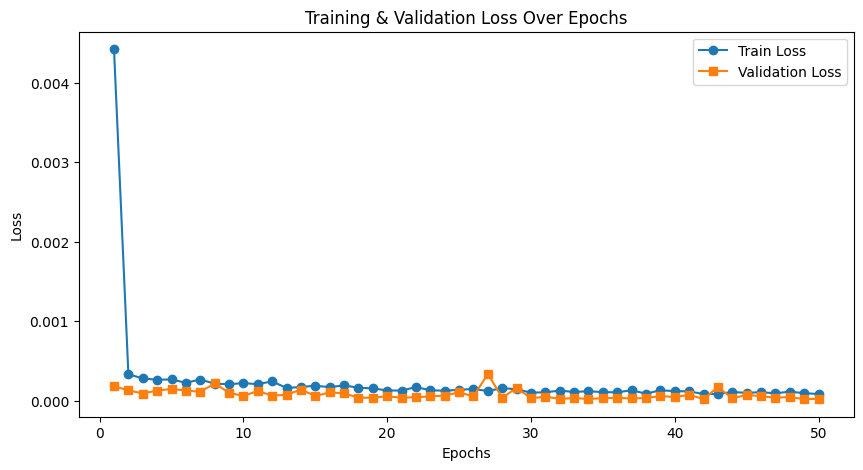

In [13]:
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', marker='o', linestyle='-')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', marker='s', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.show()

## Load trained model

In [14]:

model.load_state_dict(torch.load("lstm_nvidia_model.pth"))
model.eval()

LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

## Predictions

In [15]:
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        predictions.append(y_pred.cpu().numpy())
        actuals.append(y_batch.numpy())

## Convert to original scale

In [16]:
predictions = scaler.inverse_transform(np.vstack(predictions))
actuals = scaler.inverse_transform(np.vstack(actuals))

## Plot actual vs predicted with transparency

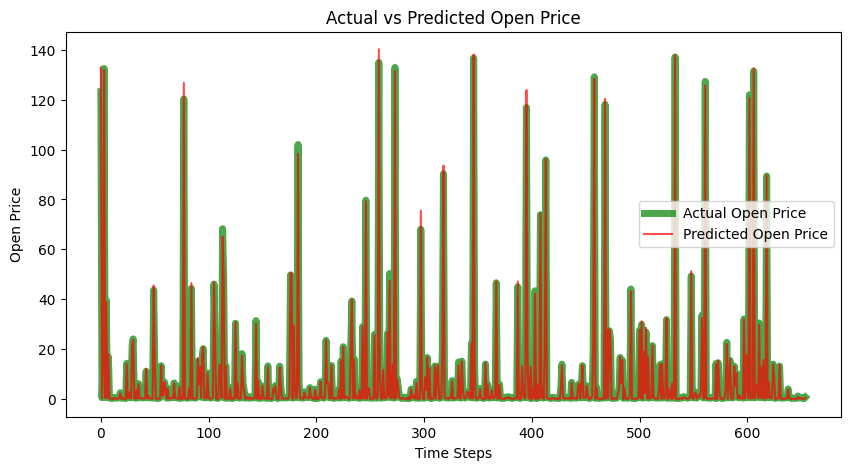

In [17]:
plt.figure(figsize=(10,5))
plt.plot(actuals, label='Actual Open Price', color='g', alpha=0.7,linewidth=5)  # Added alpha for transparency
plt.plot(predictions, label='Predicted Open Price', color='r', alpha=0.7)  # Added alpha for transparency
plt.legend()
plt.title("Actual vs Predicted Open Price")
plt.xlabel("Time Steps")
plt.ylabel("Open Price")
plt.show()

## Model evaluation

In [18]:
mse = np.mean((actuals - predictions) ** 2)
mae = np.mean(np.abs(actuals - predictions))
print(f"Test MSE: {mse:.6f}, Test MAE: {mae:.6f}")

Test MSE: 0.646395, Test MAE: 0.388177


## Identify failure cases

In [19]:
error_threshold = np.percentile(np.abs(actuals - predictions), 90)
failure_cases = np.where(np.abs(actuals - predictions) > error_threshold)[0]

## Failure Cases in Predictions

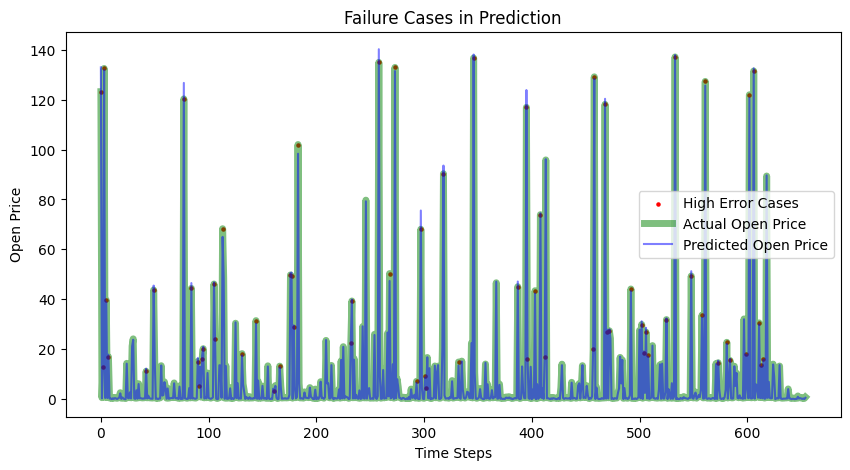

In [20]:
plt.figure(figsize=(10,5))
plt.scatter(failure_cases, actuals[failure_cases], color='r', label='High Error Cases',s=5)
plt.plot(actuals, label='Actual Open Price', color='g', alpha=0.5, linewidth=5)
plt.plot(predictions, label='Predicted Open Price', color='b', alpha=0.5)
plt.legend()
plt.title("Failure Cases in Prediction")
plt.xlabel("Time Steps")
plt.ylabel("Open Price")
plt.show()

In [ ]:
#time steps where the model failed
failure_cases